In [178]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

In [179]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  if len(label_ids) > 1:
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Add weights for circles
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  else:
    w = np.zeros_like(y)
  
  return w


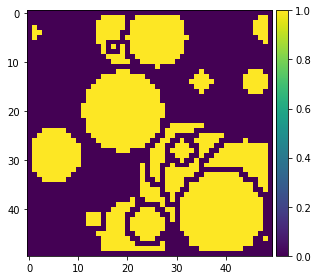

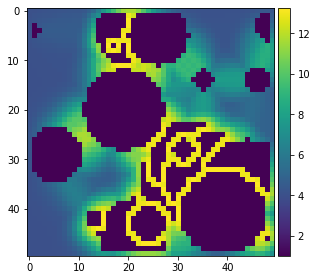

In [189]:
# Generate simulated cell mask 
y = generate_random_circles(n=10, d=50, cell_size=10)
imshow(y)
plt.show()

# Ratio of class counts 
wc = {
  0: 4, # background
  1: 1  # cells
}

# Generate weighted map
w = unet_weight_map(y, wc)
imshow(w)
plt.show()